# Homework: Autoencoding MNIST and Celebrity Faces


> **Due Date: Apr 15th, 2024 @ 10:00pm**
>
> Please turn in this completed notebook as an attachment or as a shared link to rui.xian@ucsf.edu

**Collaboration policy and more**

You're welcome (and highly encouraged) to work with and discuss this homework assignment with others in the class, and feel free to use any resources (textbooks, online notebooks, etc). The only requirement is that the final notebook that you turn in must be your own written work (no copy and pasting, please).

**Overview**

In class, we cover how Hinton and Salakhutdinov's 2006 Science Paper, ["Reducing the Dimensionality of Data with Neural Networks"](https://www.cs.toronto.edu/~hinton/science.pdf) was one of the first demonstrations of unsupervised pretraining for use in training deep neural networks. In this homework, we'll implement autoencoders in the context of MNIST. Additionally, as an optional assignment, a similar architecture can be used for a subset of CelebA dataset of celebrity faces.


## Before you get started

**1) Background reading**

Please Read Hinton and Salakhutdinov's 2006 seminal work on deep autoencoders (https://www.cs.toronto.edu/~hinton/science.pdf), as this notebook aims to recreate this important work. A few questions to think about as you read that will help you in this assignment:
  - What architecture do they use for their deep autoencoders?
  - Why were deep neural networks so much harder to train in 2006?

**2) How to run this notebook**

This Jupyter Notebook can be used in two ways:
* *Option 1: Download the notebook*

  We've included all the imports necessary for this homework. Please make sure you're running Python 3 with PyTorch (and Torchvision) installed and ready to go, along with NumPy and Matplotlib. Although you might find that these models train a bit faster on GPU, this homework assignment should be doable on most modern laptops. If you're having trouble please let us know ASAP.

* *Option 2: Run it online on Google Colaboratory*

  - Colab gives access to a GPU, so it could be useful in case you don't have CUDA installed on your computer (**Note: you can use this as an opportunity to get started on GPU training, but we recommend you develop your model and make sure everything works on CPU first**)
  - Make a copy of this notebook in your Google Drive folder: "File" -> "Save a copy in Drive..."
  - By default, Colab does not make GPUs available, but you can easily access them by selecting GPU in "Runtime" -> "Change runtime type..."
  - Remember that Colab runs in a temporary virtual machine, so all the data created while running the notebook will be lost at the end of the session, or when the runtime disconnects due to inactivity. To preserve data between sessions, there are a couple of options:
    * you can link Colab to your personal Google Drive by mounting it on your runtime, see first cell below.
    * you can download/upload files from the Files tab on the right sidebar.

**3) How to complete this assignment**

  - Fill out the relevant code blocks as indicated
  - Answer questions by writing them directly in the text block. Please keep your written answers concise, most are meant to be answered in a sentence or two.
  - Make figures showing your results and add comments with your observations.

**4) Optional exercise: CelebA Data**

Whereas MNIST is a toy dataset built into PyTorch, we can also examine a more complex feature space using a subset of 90,000 celebrity portraits from CelebA (see [Liu et al. (2014), "Deep Learning Face Attributes in the Wild"](https://arxiv.org/abs/1411.7766)). This is an optional part of the homework, but is a nice way to see how autoencoders perform on other types of visual data. There will be a .zip file of the relevant celebrity faces dataset on the Google Classroom link.

***Let's start!***

---

## Train an autoencoder on MNIST

The following command can be used to mount your personal Google Drive folder on the temporary virtual machine, so you can recover data between sessions (follow the instructions, you'll need an authorization code). Additional info [here](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA).


In [51]:
# Import all the necessary libraries
import glob
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

%matplotlib inline

from IPython.display import Image, display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [3]:
# # Skip this cell if running locally
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


You shouldn't need CUDA for this assignment, but if you want a head start, or if you just want to see the difference between using a CPU versus a GPU, set `use_cuda = True` below.
You can check if CUDA is available on your computer with: `torch.cuda.is_available()`

If you are working on Colab, make sure to activate the GPU ("Runtime" -> "Change runtime type...").

In [2]:
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
torch.manual_seed(7);

> **Question 0.1) Why is it important to set the seed for the random number generator?**

*This is because setting the seed makes the results from the script replicable.*



### 1. MNIST Dataset

As noted in class, MNIST has been widely used to benchmark new deep learning architectures and is already built into PyTorch. We provide this data as a starting point, again noting that the mean and std of the training set are calculated to be 0.1307 and 0.3081, respectively.

In [4]:
preprocessing = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(
    './bmi219_downloads', train=True, download=True,
    transform=preprocessing)

test_dataset = datasets.MNIST(
    './bmi219_downloads', train=False, download=True,
    transform=preprocessing)

21.2%

100.0%
100.0%

Extracting ./bmi219_downloads/MNIST/raw/train-images-idx3-ubyte.gz to ./bmi219_downloads/MNIST/raw

Extracting ./bmi219_downloads/MNIST/raw/train-labels-idx1-ubyte.gz to ./bmi219_downloads/MNIST/raw




100.0%
100.0%


Extracting ./bmi219_downloads/MNIST/raw/t10k-images-idx3-ubyte.gz to ./bmi219_downloads/MNIST/raw

Extracting ./bmi219_downloads/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./bmi219_downloads/MNIST/raw



In [5]:
train_dataset[123][0].size()

torch.Size([1, 28, 28])

> **Q1.1) How many examples do the training set and test set have?**

The MNIST database contains 60,000 training images and 10,000 testing images.

> **Q1.2) What's the format of each input example? Can we directly put these into a fully-connected layer?**

The format of the input example is 28*28. We cannot directly put these into a fully-connected layer because 1-dimensional data is required for fully connected layers.

> **Q1.3) Why do we normalize the input data for neural networks?**

The neural net fits better with normalized numbers. With normalized numbers, neural nets can converge faster, gradient descent works better, and numerial unstability is avoided,

> **Q1.4) In this scenario, MNIST is already split into a training set and a test set. What is the purpose of dataset splitting (and specifically, the purpose of a test set)? For modern deep learning, a three-way split into training, validation, and test sets is usually preferred, why?**

Datasets are typically split into training, validation, and test sets to evaluate model performance and ensure robustness. The training set is used to fit the model, adjusting weights based on learning algorithms. The validation set provides an unbiased evaluation while tuning hyperparameters and model configurations, helping to avoid overfitting by allowing iterative adjustments based on performance metrics. Finally, the test set offers an objective assessment of the final model's performance, ensuring it generalizes well to new, unseen data. This three-way split, especially crucial in modern deep learning, manages the bias-variance trade-off, separates model tuning from final evaluation, and supports effective hyperparameter tuning, ultimately leading to more reliable and powerful models.

### 2. Using DataLoaders for MNIST

Set up the DataLoader objects below. Although the arguments are prepopulated, you may need to change the batch sizes or other arguments during training.

In [6]:
BATCH_SIZE = 256  # <-- Please change this as necessary
NUM_WORKERS = 8  # <-- Use more workers for more CPU threads

In [7]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS)

In [8]:
one_batch=next(iter(train_loader))
one_batch[0].size()

torch.Size([256, 1, 28, 28])

> **Q2.1) It's recommended to shuffle the training data over each epoch, but this isn't typically the case for the test set, why?**

Shuffling the training data for each epoch is a recommended practice in machine learning to prevent order bias, improve generalization, and promote smoother convergence by ensuring each batch is representative of the overall dataset. This is crucial during training to help the model learn robust features and avoid learning any specific sequence of data. In contrast, the test set is not shuffled because it is used solely for evaluating the model's performance after training is complete. Keeping the test set in a fixed order ensures consistency in evaluation, maintains simplicity in the assessment process, and guarantees reproducibility of results, as the test set's order doesn't affect the learning process or the outcome of the model evaluation.

> **Q2.2) What seems to be a good batch size for training? What happens if you train with a batch size of 1? What about a batch size equal to the total training set?**

Choosing an optimal batch size for training neural networks involves a balance between computational efficiency and model performance. A common batch size ranges from 32 to 128, providing a good compromise between the memory usage and the benefit of parallel processing on modern hardware. Training with a batch size of 1, known as stochastic gradient descent, allows for quick updates to the model but can result in high variance during training and potentially poor convergence as the model reacts to the noise in individual samples. On the other hand, using a batch size equal to the total training set, known as batch gradient descent, provides a stable error gradient and a smoother convergence but can be very computationally intensive and slow, as it requires the entire dataset to be processed simultaneously. This method also makes less efficient use of GPU parallelism and may lead to local minima or saddle points due to the uniformity of updates across epochs. Therefore, a moderate batch size not only exploits hardware efficiently but also strikes a balance between the extremes of variance and computation.

> **Q2.3) The PyTorch DataLoader object is an iterator that generates batches as it's called. Try to pull a few images from the training set to see what these images look like. Does the DataLoader return only the images? What about the labels?**

The PyTorch DataLoader object is an essential component for efficiently managing batches of data during training, acting as an iterator that generates batches of data as it's called upon. When used with image datasets, such as those typically found in computer vision tasks, the DataLoader not only retrieves batches of images but also the corresponding labels for each image, making it indispensable for supervised learning. This dual retrieval allows for simultaneous access to both the input data (images) and the targets (labels), which is crucial for training models to associate specific inputs with correct outputs. The DataLoader ensures that each batch is a subset of the data, shuffled if specified, and handles the loading and transformation of data in a way that optimizes computation and memory usage, facilitating efficient and effective model training.

### 3. Define your neural network architecture

With your data and dataloaders appropriately set, you're ready to define a network architecture. In this homework, we'll ask you to evaluate two different architectures.

For the first (we'll call it `HNet` in this homework), please implement Hinton's 2006 architecture of 7-hidden layers:

```[1000 x 500 x 250 x 2 x 250 x 500 x 1000]. ```

For the second, implement your own autoencoder architecture, `MyNet`, again using a bottleneck dimension of 2. As a note, the larger your model, the longer it will take to train. Can you achieve similar performance to the model above using a more condensed model?

**Tips:**
* Try different activation functions (Tanh, Sigmoid, ReLU, etc)
* A sequence of layers can be defined more easily using `nn.Sequential`, see [docs](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential)
* Split your network into an `.encoder()` and a `.decoder()`, that will be called sequentially in `.forward()`. This will be useful later on when we'll ask to visualize the low-dimensional embeddings ("latent space") produced by the encoder.

In [20]:
class HNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250, 2),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 250),
            nn.ReLU(),
            nn.Linear(250, 500),
            nn.ReLU(),
            nn.Linear(500, 1000),
            nn.ReLU(),
            nn.Linear(1000, 784),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [21]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 1000),
            nn.ReLU(),
            nn.Linear(1000, 250),
            nn.ReLU(),
            nn.Linear(250, 2),
            nn.ReLU(),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 250),
            nn.ReLU(),
            nn.Linear(250, 1000),
            nn.ReLU(),
            nn.Linear(1000, 784),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

> **Q3.1) What activation functions did you use, and why?**

I used the ReLU function as my activation function. ReLU (Rectified Linear Unit) is used as the activation function in many neural network designs, including the ones described above, primarily due to its simplicity and effectiveness in training deep neural networks. ReLU function, which outputs the input itself if it is positive and zero otherwise, helps in reducing the vanishing gradient problem that is common with other activation functions like Sigmoid or Tanh. This problem occurs when gradients are backpropagated through the network and become increasingly small, effectively preventing weights from changing their values, which can halt the network from learning further. ReLU's linear and non-saturating form allows for faster convergence during training since the gradients are either zero (for negative inputs) or equal to the input (for positive inputs), which leads to more efficient gradient propagation across many layers without diminishing over depth. Additionally, ReLU is computationally less expensive because it involves simpler mathematical operations.

### 4. Write your own training function

Write your own training function that takes your **model**, an **optimizer**, and a **training criterion**, and iterates over the **training set**.
* *Hint*: Because an autoencoder is a form of unsupervised learning, we won't need to use the labels like in the MNIST classification example. Keep in mind the format of the images and whether they're compatible with feed-forward networks.
* For each epoch, print and record (in an array or list) the training loss.
* You may want to save the model and its weights on file at regular intervals ([checkpointing](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference)). In order to visualize the autoencoder's learning process, we suggest to save at least three timepoints: early, intermediate, and final (for instance, if your model converges after 60 epochs, save your model at 5 epochs, 30 epochs, and 60 epochs).

A few useful tips:
- Feel free to look at the MNIST classification notebook from previous recitations and use it as a template.
- Printing out the intermediate variables and their shape at each step can be helpful for debugging.

In [25]:
def train(train_loader, model, optimizer, criterion,
          n_epochs=10, model_name='model1', **kwargs):

    model.train()
    loss_history = []

    for epoch in range(n_epochs):
        train_loss = 0.0
        for data in train_loader:
            # load just the images but not the labels
            images, _ = data
            # flatten images
            images = images.view(images.size(0), -1)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            # calculate the loss
            loss = criterion(outputs, images)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*images.size(0)

        average_loss = train_loss / len(train_loader)
        loss_history.append(average_loss)
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {average_loss:.4f}')

        # add checkpoints to the model
        if epoch % 10 == 0:  
            torch.save(model.state_dict(), f'{model_name}_epoch_{epoch+1}.pth')

    return loss_history

### 5. Define your optimization and evaluation criterion

Define an optimizer and criterion (loss function) for your neural network training. To setup your optimizer, you'll have to instantiate your models above, and choose a learning rate. Try a few different optimizers and learning rates to get a sense of what will train within a reasonable timeframe (if your deep network isn't too deep, reaching convergence shouldn't take more than 5-10 minutes with the right choice of learning rate and optimizer).

> **Q5.1) What loss function is suited to this problem?**

The Mean Squared Error (MSE) loss function is suited to this problem. The Mean Squared Error (MSE) loss function measures the average squared difference between the predicted and actual values. It's particularly suited for regression problems and scenarios like training autoencoders where the objective is to have the predicted outputs (reconstructions of the input data) closely match the original inputs. In the context of an autoencoder, using MSE helps to quantify how well the model is reconstructing the input images by penalizing the model more for larger errors between the reconstructed images and the original ones, thus encouraging more accurate reconstructions.

> **Q5.2) Try a few optimizers, what seemed to work best?**

MSE loss function works the best among all different loss functions that I tried including 1) Mean Absolute Error (MAE), 2) Mean Squared Logarithmic Error (MSLE), and 3) Huber Loss, a combination of MSE and MAE.

> **Q5.3) What's the effect of choosing different batch sizes?**

A smaller batch size tends to provide a more noisy gradient estimate at each update, which can help escape local minima but might lead to less stable training and require more epochs to converge. Conversely, a larger batch size offers a more accurate gradient estimate, which generally leads to more stable and faster convergence in terms of the number of updates. However, it may require more computational memory and could potentially lead to sharper minima in the optimization landscape, which might generalize poorly on new data. Therefore, the choice of batch size is often a balance between available computational resources, training stability, and model generalization capabilities.

In [28]:
### Instantiate your model
### Define your loss function (training criterion)
### Choose your optimizer

model1 = HNet()
model2 = MyNet()
criterion = nn.MSELoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

### 6. Run your training loop

It's a great idea to monitor the early epochs of your training ("babysit your training") to keep an eye on learning. Does the learning rate seem too high? too low?

(**Hint: it's recommended that you just test a single epoch at a time while you write your training function, to debug and make sure everything is working appropriately.**)

In [29]:
### Set a number of training epochs and train your model.
number_of_training_epoch = 150
print('Training model 1:\n')
loss_history1 = train(train_loader, model1, optimizer1, criterion, n_epochs=number_of_training_epoch, model_name='HNet')
print('Training model 2:\n')
loss_history2 = train(train_loader, model2, optimizer2, criterion, n_epochs=number_of_training_epoch, model_name='MyNet')

Training model 1:

Epoch [1/150], Loss: 219.8167
Epoch [2/150], Loss: 218.9577
Epoch [3/150], Loss: 218.8878
Epoch [4/150], Loss: 218.6448
Epoch [5/150], Loss: 218.0137
Epoch [6/150], Loss: 217.8319
Epoch [7/150], Loss: 217.7844
Epoch [8/150], Loss: 217.7943
Epoch [9/150], Loss: 217.7795
Epoch [10/150], Loss: 217.7722
Epoch [11/150], Loss: 217.7630
Epoch [12/150], Loss: 217.7494
Epoch [13/150], Loss: 217.7252
Epoch [14/150], Loss: 217.7222
Epoch [15/150], Loss: 217.7133
Epoch [16/150], Loss: 217.6793
Epoch [17/150], Loss: 217.5828
Epoch [18/150], Loss: 217.4025
Epoch [19/150], Loss: 217.4042
Epoch [20/150], Loss: 217.3929
Epoch [21/150], Loss: 217.3891
Epoch [22/150], Loss: 217.3788
Epoch [23/150], Loss: 217.3793
Epoch [24/150], Loss: 217.3678
Epoch [25/150], Loss: 217.3631
Epoch [26/150], Loss: 217.3658
Epoch [27/150], Loss: 217.3679
Epoch [28/150], Loss: 216.9017
Epoch [29/150], Loss: 216.8054
Epoch [30/150], Loss: 216.8042
Epoch [31/150], Loss: 216.8006
Epoch [32/150], Loss: 216.802

In your training loop, we requested that you store your training loss for each epoch. Using Matplotlib, please plot your training loss as a function of epochs.

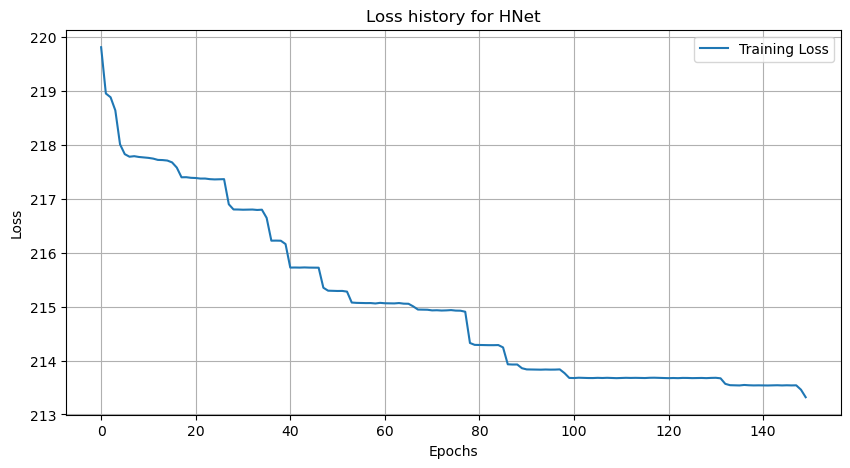

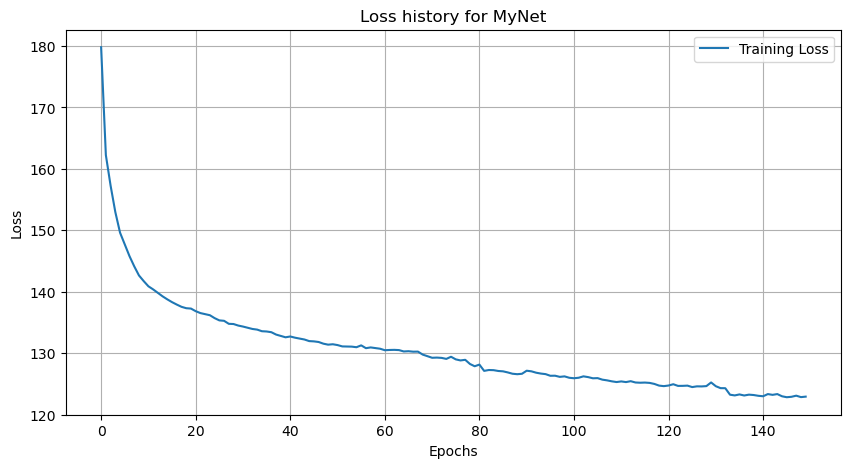

In [30]:
### Plot loss curve using Matplotlib
# Plotting function
def plot_loss(loss_history, plot_title):
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, label='Training Loss')
    plt.title(plot_title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(loss_history1, 'Loss history for HNet')
plot_loss(loss_history2, 'Loss history for MyNet')

> **Q6.1)  How do you know when your network is done training?**

Determining when a network is done training based on loss history involves observing when the loss has effectively plateaued, indicating that the model is no longer making significant improvements in learning from the training data. This is often referred to as convergence. Additionally, one must also watch for signs of overfitting, where the training loss continues to decrease while validation loss begins to increase, suggesting that the model is learning the noise in the training data rather than generalizing from it. Effective strategies include setting a stopping criterion such as a minimum change in loss over a number of epochs (early stopping), using validation loss as a guide rather than training loss to avoid overfitting, and potentially employing techniques like learning rate reductions when the decrease in loss slows down or plateaus.



Another way to check if your models (`HNet` and `MyNet`) are well trained is to plot a few image reconstructions to see how well your models do.

In [41]:
# extract 6 figures from training DataLoader
mini_batch, _ = next(iter(train_loader))
n_examples = min(6, mini_batch.shape[0])
examples = mini_batch[:n_examples]

# compute reconstructions
with torch.no_grad():
    reconstr_examples = model2.forward(
        examples.view(n_examples, -1).to(device))

# save image with original v. reconstructed images
comparison = torch.cat([
    examples,
    reconstr_examples.view(-1, 1, 28, 28).cpu()])
save_image(comparison.cpu(), 'training_reconstruction.png', nrow=n_examples)

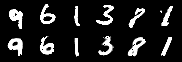

In [42]:
Image('training_reconstruction.png', width=300)

> **Q6.2) What does `torch.no_grad()` do?**

In this case, we would like to perform a forward pass through the network without influencing the gradient computations of subsequent training steps. torch.no_grad() ensures that these operations are excluded from the gradient computation graph.



### 7. Visualize the learning process

We'll next try to visualize how well the model is learning on the **test set**. To do this, we'll first visualize the "learning process" by viewing reconstruction at various stages.

* Using your checkpoints saved during training, plot a batch of images from the test set and their corresponding reconstructions based on each of your saved models over time. You should see the quality of the reconstructions improving over time.
* To visualize images, you can use the helper functions provided below.


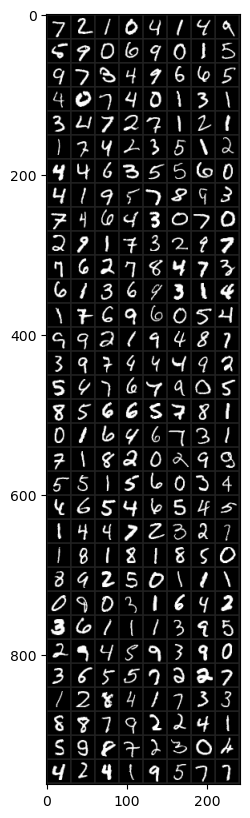

In [43]:
### Helper Functions for Plotting Multiple Images
def imshow(inp,
           figsize=(10,10),
           mean=0.1307, # for MNIST train
           std=0.3081, # for MNIST train
           title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().detach()
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=figsize)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def reconstructions_from_batch(model, batch):
    batch = batch.view(-1, 28 * 28).to(device)
    reconstruction = model(batch)
    return reconstruction.reshape(batch.shape[0],1,28,28)

# Get a batch of training data
batch, classes = next(iter(test_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(batch)
imshow(out)

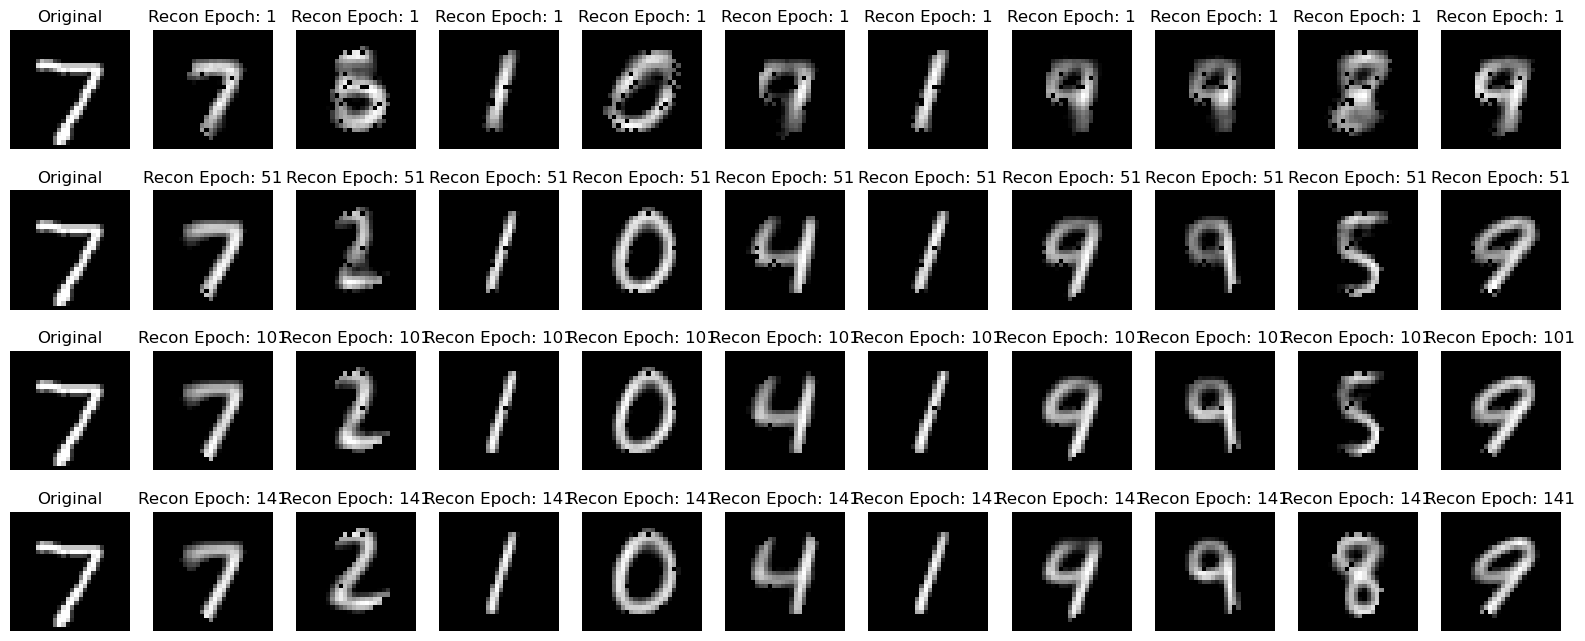

In [44]:
### Iterate over checkpoints and plot reconstruction
### figures from the test set.

def visualize_reconstructions(model, test_loader, checkpoint_paths):
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images = images.view(images.size(0), -1)
    
    fig, axes = plt.subplots(nrows=len(checkpoint_paths), ncols=11, figsize=(20, 2 * len(checkpoint_paths)))
    
    for idx, path in enumerate(checkpoint_paths):
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint)
        
        with torch.no_grad():
            reconstructed = model(images).view(-1, 1, 28, 28)

        axes[idx, 0].imshow(images[0].view(28, 28), cmap='gray')
        axes[idx, 0].set_title("Original")
        axes[idx, 0].axis('off')
        
        for i in range(10):
            axes[idx, i+1].imshow(reconstructed[i].view(28, 28), cmap='gray')
            axes[idx, i+1].set_title(f"Recon Epoch: {path.split('_')[-1].split('.')[0]}")
            axes[idx, i+1].axis('off')
    plt.show()

checkpoint_paths = ['saved_states/MyNet_epoch_1.pth', 
                    'saved_states/MyNet_epoch_51.pth', 
                    'saved_states/MyNet_epoch_101.pth',
                      'saved_states/MyNet_epoch_141.pth']
visualize_reconstructions(model2, test_loader, checkpoint_paths)


### 8. Visualize the latent space

As discussed in class, the first half of an autoencoder (the *encoder*) maps the original input into a lower-dimensional latent space.
* Just as shown in Hinton and Salakhutdinov, run your test set of 10,000 MNIST digits through the **encoding layer** of one of the trained networks above. Each sample should readily map to a 2-dimension point. To do this, it will be helpful to fill out a new function, **encode** below, that takes in your trained model and the `test_dataloader` to produce 2d latent embeddings and their corresponding labels.
* Plot each point in these two dimensions, and color each point in this **latent space** by their known **labels**.


In [46]:
### Write a helper function to grab examples from the test_loader to generate
### pairs of embeddings and their associated labels

def encode(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    latent_embeddings = []
    labels = []

    with torch.no_grad():  # Disable gradient computation
        for data, target in test_loader:
            data = data.to(device)
            encoded = model.encoder(data.view(data.size(0), -1))  # Ensure input shape is correct
            latent_embeddings.append(encoded.cpu().numpy())  # Append the result as a NumPy array
            labels.append(target.numpy())  # Append labels as NumPy array

    # Concatenate all batches
    latent_embeddings = np.concatenate(latent_embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)
    return latent_embeddings, labels

latent_embeddings, labels = encode(model2, device, test_loader)



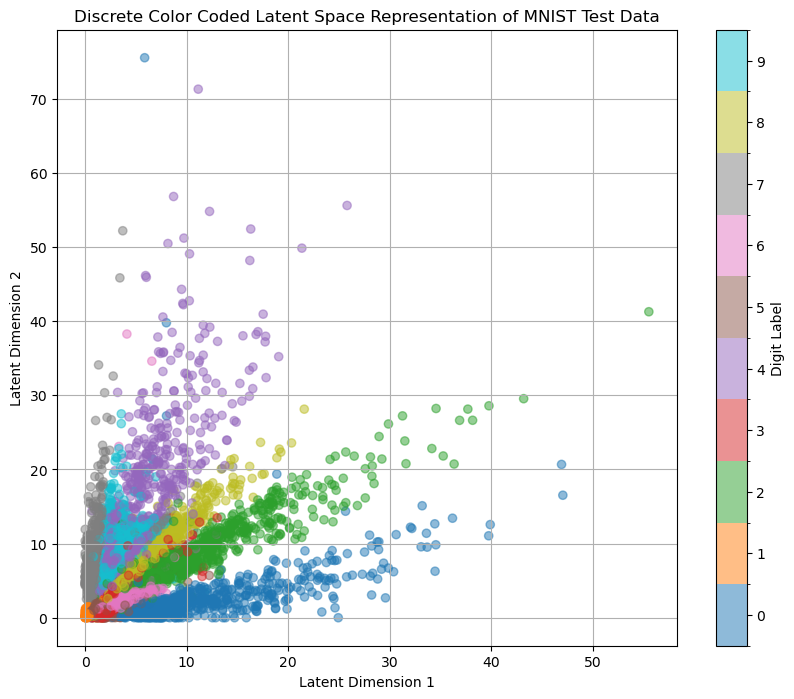

In [53]:
### Plot latent space representation color-coded
### according to their "true" labels

def plot_latent_space(latent_embeddings, labels):
    # Create a discrete colormap
    cmap = plt.get_cmap('tab10')  # 'tab10' has 10 distinct colors
    norm = mcolors.BoundaryNorm(np.arange(-0.5, 10, 1), cmap.N)  # Define boundaries for discrete colors

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_embeddings[:, 0], latent_embeddings[:, 1], c=labels, cmap=cmap, norm=norm, alpha=0.5)
    colorbar = plt.colorbar(scatter, ticks=np.arange(0, 10))
    colorbar.set_label('Digit Label')

    plt.title('Discrete Color Coded Latent Space Representation of MNIST Test Data')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.grid(True)
    plt.show()

plot_latent_space(latent_embeddings, labels)

> **Q8.1) Does your autoencoder separate out different classes effectively? What classes seem to be closer and what classes are farther apart in this latent space?**

The autoencoder separate out different classes effectively for the most part as they appear to be relatively separated at the latent space. However, 4 and 9 seems to be relatively close to each other, potentially pointing to the similarity in handwriting between these 2 digits.

## Optional (advanced): Train an autoencoder on CelebA Faces

Real-world images tend to be far more complex than digits from MNIST. As an optional exercise for your own interest, or for students looking for more experience, we'll investigate a subset of CelebA below.

We provide the images in a .zip file (`faces.zip`) in the class's Google Drive folder, which contains a "train" and "test" set of 80k and 10k images, respectively. Although these are color, RGB images, below we've set up the datasets to convert these to grayscale with precomputed means (0.4401) and stds (0.2407), for convenience and easier compute.

In [ ]:
### Download faces.zip and unzip it into bmi219_downloads/

In [ ]:
preprocessing = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.4401,), (0.2407,)),
])

train_dataset = datasets.ImageFolder(
    'bmi219_downloads/Faces/train',
    transform=preprocessing)

test_dataset = datasets.ImageFolder(
    'bmi219_downloads/Faces/test',
    transform=preprocessing)

As above, you'll want to:

1. set up your dataloaders and visualize some of the images
2. set up your autoencoder network architecture
3. define your training criterion and optimizer
4. train your network
    
In this case, you should be able to reuse much of your code from above. Consider a few questions:

1. How well do complex images like faces work with a latent dimension of 2?
2. Do reconstructions look better with a larger bottleneck?
3. What kind of features are poorly reconstructed? What happens to sunglasses, hats, and hands?
4. Try sampling the 2-d latent space close to existing examples (by adding some noise...) or randomly. What do the generated images look like?